In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# Intro

#### Welcome to a demo notebook on different methods for ingesting diverse data into ROICaT. There are 3 sections:

- [Section 1](#Section-1): Ingesting data from **different segmentation packages** (Suite2p, CaImAn, CNMF, NWB, etc.).
- [Section 2](#Section-2): **Understanding** the `Data_roicat` class.
- [Section 3](#Section-3): Ingesting **custom data**.



Import libraries

In [2]:
import inspect
import tempfile
from pathlib import Path

from IPython.display import display
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2
import roicat

___

# Section 1
## Ingesting different data sources

We've made a few subclasses that make ingesting this data from various sources easy. These sources include:
```
- Raw data ----- via Data_roicat
- Suite2p ------ via Data_suite2p or Data_roiextractors
- CaImAn ------- via Data_caiman or Data_roiextractors
- CNMF --------- via Data_roiextractors
- NWB ---------- via Data_roiextractors
- Sima --------- via Data_roiextractors
- EXTRACT ------ via Data_roiextractors
```

##### Download data

Let's first download a single dataset that has been processed by each segmentation method above. This data was curated by the good folks at [CatalystNeuro](https://www.catalystneuro.com/), which makes [roiextractors](https://github.com/catalystneuro/roiextractors).

In [ ]:
dir_download_temp = tempfile.gettempdir()
path_download_temp = str(Path(dir_download_temp) / 'datasets_roiextractors.zip')

roicat.helpers.download_file(
    url='https://osf.io/db5h8/download',
    path_save=path_download_temp,
)
paths_extracted = roicat.helpers.extract_zip(
    path_zip=path_download_temp,
    path_extract=None,
    verbose=True,
);

### Make `Data_roiextractors` objects
Let's make first `roiextractors` objects out of each of these datasets.

In [ ]:
import roiextractors

dir_segData = paths_extracted[0]

re_caiman = roiextractors.CaimanSegmentationExtractor(file_path=str(Path(dir_segData) / 'caiman' / 'caiman_analysis.hdf5'))
re_cnmfe = roiextractors.CnmfeSegmentationExtractor(file_path=str(Path(dir_segData) / 'cnmfe' / '2014_04_01_p203_m19_check01_cnmfeAnalysis.mat'))
re_EXTRACT = roiextractors.ExtractSegmentationExtractor(file_path=str(Path(dir_segData) / 'extract' / 'extract_public_output.mat'), sampling_frequency=30)
re_NWB = roiextractors.NwbSegmentationExtractor(file_path=str(Path(dir_segData) / 'nwb' / 'nwb_test.nwb'))
re_s2p = roiextractors.Suite2pSegmentationExtractor(folder_path=str(Path(dir_segData) / 'suite2p'), plane_no=0)


Next, let's convert the `roiextractors` object to `Data_roicat` objects by using the `Data_roiextractors` class:

In [ ]:
data_re_caiman = roicat.data_importing.Data_roiextractors(re_caiman)
display(data_re_caiman)
data_re_cnmfe = roicat.data_importing.Data_roiextractors(re_cnmfe)
display(data_re_cnmfe)
data_re_EXTRACT = roicat.data_importing.Data_roiextractors(re_EXTRACT)
display(data_re_EXTRACT)
data_re_NWB = roicat.data_importing.Data_roiextractors(re_NWB)
display(data_re_NWB)
data_re_s2p = roicat.data_importing.Data_roiextractors(re_s2p)
display(data_re_s2p)


### Make `Data_suite2p` and `Data_caiman` objects

For suite2p and CaImAn, we recommend using our built in data ingestion classes. These collect a little more information and can be faster:

In [ ]:
data_roicat_s2p = roicat.data_importing.Data_suite2p(
    paths_statFiles=str(Path(dir_segData) / 'suite2p' / 'plane0' / 'stat.npy'),
    paths_opsFiles=str(Path(dir_segData) / 'suite2p' / 'plane0' / 'ops.npy'),
)
display(data_roicat_s2p)

data_roicat_caiman = roicat.data_importing.Data_caiman(
    paths_resultsFiles=str(Path(dir_segData) / 'caiman' / 'caiman_analysis.hdf5')
)
display(data_roicat_caiman)

## Make multisession objects

Normally we are using ROICaT with multiple sessions of data. To do this, just pass in a list of paths or roiextractors objects where each element is from one session.

#### Multisession `Data_roiextractors`

We will simulate having multiple sessions of a dataset from the EXTRACT pipeline:

In [ ]:
re_multi_EXTRACT = [roiextractors.ExtractSegmentationExtractor(file_path=path, sampling_frequency=30) for path in [str(Path(dir_segData) / 'extract' / 'extract_public_output.mat')]*10]

print(f'Number of sessions: {len(re_multi_EXTRACT)}')

Now let's make a single `Data_roiextractors` object containing all these sessions:

In [ ]:
data_roicat_multi_EXTRACT = roicat.data_importing.Data_roiextractors(segmentation_extractor_objects=re_multi_EXTRACT)
display(data_roicat_multi_EXTRACT)

You'll see that this object now stores data from all 10 of these sessions.

#### Multisession `Data_suite2p`

Now let's do it with the `Data_suite2p` class (recommended for suite2p data). This data was collected and provided by Valerio Francioni while in Mark Harnett's lab at MIT:

*Download*

In [ ]:
## Define temporary directory to save files to
dir_temp = tempfile.gettempdir()
path_test_temp = str(Path(dir_temp) / 'data_valerio.zip')

## Download zip file
roicat.helpers.download_file(
    url='https://osf.io/ru4x5/download',
    path_save=path_test_temp,
)
## Extract zip file
paths_extracted = roicat.helpers.extract_zip(
    path_zip=path_test_temp,
    path_extract=None,
)
dir_test_data = paths_extracted[0]
display(f'Downloaded and extracted folder containing test data to: {dir_test_data}')

*Initialize class*

In [ ]:
## Make paired lists of all the stat.npy and ops.npy files
paths_stat = roicat.helpers.find_paths(
    dir_outer=dir_test_data,
    reMatch='stat.npy',
    depth=4,
)
paths_ops = [str(Path(p).parent / 'ops.npy') for p in paths_stat]

## Initialize the class
data_roicat_multi_suite2p = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_stat,
    paths_opsFiles=paths_ops,
)

display(data_roicat_multi_suite2p)

And that's it, you now know how to use data from almost any segmentation pipeline to make a data object that can be used for any of the 3 pipelines in ROICaT. Let's finish by looking at some of the properties of these objects.

# Section 2
## Understanding the `Data_roicat` class

All raw data is ingested and stored through a custom python superclass called `Data_roicat` which standardizes data that comes from different sources. The main types of data it ingests are:
1. `spatialFootprints`: The images of individual ROIs within the field of view
2. `FOV_images`: The image of the field of view itself (e.g. the mean fluorescence image of the raw movie)
3. `ROI_images`: Small images of individual ROIs
4. `class_labels`: The labels associated with each ROI
5. `um_per_pixel`: The resolution of the imaging field of view

Let's demonstrate on **Suite2p** multisession test data from Valerio.

#### `ROI_images`

In [ ]:
roicat.visualization.display_toggle_image_stack(data_roicat_multi_suite2p.ROI_images[0], image_size=(200,200))

#### `FOV_images`

In [ ]:
roicat.visualization.display_toggle_image_stack(data_roicat_multi_suite2p.FOV_images, image_size=(400,400))

#### `spatialFootprints`
ROIs from each session are stored as a scipy sparse array. Each sparse array is of shape: (`n_ROIs`, `height * width`). Notice that height and width dimension have been flattened into one dimension. We can reconstruct what a max intensity projection of ROIs looks like with the following code.

In [ ]:
display(data_roicat_multi_suite2p.spatialFootprints)

height_width = (data_roicat_multi_suite2p.FOV_height, data_roicat_multi_suite2p.FOV_width)

FOVs_MIP_ROIs = [sf.max(0).toarray().reshape(height_width[0], height_width[1]) for sf in data_roicat_multi_suite2p.spatialFootprints]

roicat.visualization.display_toggle_image_stack(FOVs_MIP_ROIs)

##### Check completeness of object

Lastyl, there are 3 things a data object can be used for in ROICaT: **tracking**, **classification training**, and **classification inference**. Let's check to see what we can do with the data object we just made:

In [ ]:
data_roicat_multi_suite2p.check_completeness()

Looks like we can do **tracking** and **classification-inference**, but not **classification-training** because we don't have class labels for each ROI. This makes sense because this is a raw dataset and labeling wasn't performed.

# Section 3
## Custom data class

We can also make a `Data_roicat` object from scratch by populating the required data for what we want to do. Let's start with an empty object and call the `.check_completeness()` to see what it can do:

In [7]:
data_custom = roicat.data_importing.Data_roicat()

display(data_custom.check_completeness())

RH WARNING: Classification-Inference incomplete because following attributes are missing: ['ROI_images', 'um_per_pixel']
RH WARNING: Classification-Training incomplete because the following attributes are missing: ['ROI_images', 'um_per_pixel', 'class_labels']
RH WARNING: Tracking incomplete because the following attributes are missing: ['ROI_images', 'um_per_pixel', 'spatialFootprints', 'FOV_images']
Cannot check validity of class_labels and ROI_images because one or both do not exist as attributes.
Cannot check validity of spatialFootprints and FOV_images because one or both do not exist as attributes.
Data_roicat object completeness: {'classification_inference': False, 'classification_training': False, 'tracking': False}


{'classification_inference': False,
 'classification_training': False,
 'tracking': False}

As mentioned before, there are 5 key types of data that can be stored in a `Data_roicat` object:
1. `spatialFootprints`: The images of individual ROIs within the field of view
2. `FOV_images`: The image of the field of view itself (e.g. the mean fluorescence image of the raw movie)
3. `ROI_images`: Small images of individual ROIs
4. `class_labels`: The labels associated with each ROI
5. `um_per_pixel`: The resolution of the imaging field of view

Different combinations are needed for each of the 3 pipelines, which can be viewed in the above print statement from `.check_completeness()`

### Prepare data for *Classification-inference*

Let's add the necessary data to do **'Classification-Inference'**: `'ROI_images'`, `'um_per_pixel'`. 

Let's just make up some fake data with the correct properties:

In [4]:
## Helper function for making fake ROI_images data
def make_ROIs(
    n_sessions=10,
    max_rois_per_session=100,
    size_im=(36,36)
):
    import numpy as np
    import torch
    import torchvision

    roi_prototype = torch.zeros(size_im, dtype=torch.uint8)
    roi_prototype[*torch.meshgrid(torch.arange(size_im[0]//2-8, size_im[0]//2+8), torch.arange(size_im[1]//2-8, size_im[1]//2+8), indexing='xy')] = 255
    transforms = torch.nn.Sequential(*[
        torchvision.transforms.RandomPerspective(distortion_scale=0.9, p=1.0),
        torchvision.transforms.RandomAffine(0, scale=(2.0, 2.0))
    ])
    ROIs = [[transforms(torch.as_tensor(roi_prototype[None,:,:]))[0].numpy() for i_roi in range(max_rois_per_session)] for i_sesh in range(n_sessions)]
    ROIs = [np.stack([roi for roi in ROIs_sesh if roi.sum() > 0], axis=0) for ROIs_sesh in ROIs]

    return ROIs

Number of sessions: 10
Number of ROIs per session: [100, 100, 100, 100, 100, 99, 100, 99, 99, 100]
Shape of each ROI image: (36, 36)



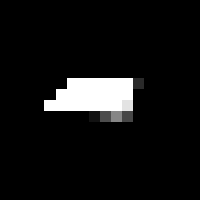

In [5]:
ROI_images = make_ROIs(
    n_sessions=10,
    max_rois_per_session=100,
    size_im=(36,36),
)

print(f'Number of sessions: {len(ROI_images)}')
print(f'Number of ROIs per session: {[rois.shape[0] for rois in ROI_images]}')
print(f'Shape of each ROI image: {ROI_images[0][0].shape}')

roicat.visualization.display_toggle_image_stack(ROI_images[0], image_size=(200,200))

We've made `ROI_images`, which is a list of lists of 3D numpy arrays:

Now let's add the ROIs_images to the data object. We will also add a `um_per_pixel` value, which is necessary for classification-inference:

In [8]:
data_custom.set_ROI_images(ROI_images, um_per_pixel=1.5)

data_custom.check_completeness()

Starting: Importing ROI images
Completed: Imported 10 sessions. Each session has [100, 100, 100, 100, 100, 99, 100, 99, 99, 100] ROIs. Total number of ROIs is 997. The um_per_pixel is 1.5 um per pixel.
RH WARNING: Classification-Training incomplete because the following attributes are missing: ['class_labels']
RH WARNING: Tracking incomplete because the following attributes are missing: ['spatialFootprints', 'FOV_images']
Cannot check validity of class_labels and ROI_images because one or both do not exist as attributes.
Cannot check validity of spatialFootprints and FOV_images because one or both do not exist as attributes.
Data_roicat object completeness: {'classification_inference': True, 'classification_training': False, 'tracking': False}


{'classification_inference': True,
 'classification_training': False,
 'tracking': False}

Notice that `'classification_inference': True'`, so we can use this data object for the **classification_inference** and **classification_by_Drawing** notebooks/pipelines.

### Prepare data for *Tracking*

For tracking we need: `spatialFootprints`, `FOV_images`, `ROI_images`, and `um_per_pixel`.

What is `spatialFootprints`? It is an array containing the spatial mask of each ROI within the full field of view (FOV). We use a compressed datatype called a ***sparse matrix*** which dramatically speeds up handling this kind of data. The `Data_roicat` object can ingest two kinds of input for spatial footprints:
1. A list of normal numpy arrays of shape **(n_roi, FOV_height, FOV_width)**
2. A list of our natively used datatype: `scipy.sparse.csr_matrix` arrays of shape **(n_roi, FOV_height * FOV_width)**

Again, let's just make up some fake data with the correct properties:

Number of sessions: 5
Number of ROIs per session: [50, 48, 49, 50, 50]
Shape of each spatialFootprints image: (300, 400)



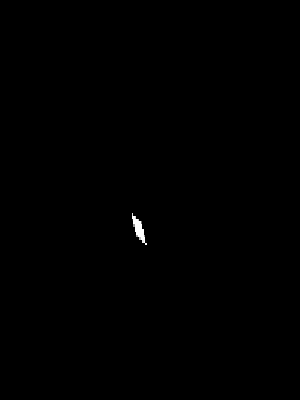

In [9]:
n_sessions = 5
size_im = (300,400)
max_rois_per_session = 50

spatialFootprints = make_ROIs(
    n_sessions=n_sessions,
    max_rois_per_session=max_rois_per_session,
    size_im=size_im,
)

print(f'Number of sessions: {len(spatialFootprints)}')
print(f'Number of ROIs per session: {[sf.shape[0] for sf in spatialFootprints]}')
print(f'Shape of each spatialFootprints image: {spatialFootprints[0][0].shape}')

roicat.visualization.display_toggle_image_stack(spatialFootprints[0], image_size=size_im)

Now let's make a new `Data_roicat` and populate it with `spatialFootprints`. Again we need to specify a `um_per_pixel` value.

In [ ]:
data_custom = roicat.data_importing.Data_roicat()

data_custom.set_spatialFootprints(
    spatialFootprints=spatialFootprints,
    um_per_pixel=2.0,
)

We could have also converted our input `spatialFootprints` into sparse arrays:

In [ ]:
import scipy.sparse

spatialFootprints_sparse = [scipy.sparse.csr_matrix(sf.reshape(sf.shape[0], -1)) for sf in spatialFootprints]

data_custom.set_spatialFootprints(
    spatialFootprints=spatialFootprints_sparse,
    um_per_pixel=2.0,
)

We also need `FOV_images` for tracking, so lets make some fake mean FOV images **with the same shape and number of sessions as spatial footprints**:

In [ ]:
data_custom.set_FOV_images([np.random.rand(*size_im) for ii in range(n_sessions)])

Finally, we can convert the `spatialFootprints` into ROI_images:

In [ ]:
data_custom._transform_spatialFootprints_to_ROIImages(out_height_width=(36, 36));

Let's look at `.check_completeness()` again to see what we can do with this data object now:

In [ ]:
data_custom.check_completeness()

We can do **tracking** and **classification-inference** now!

Let's finish the exercise by adding `class_labels` so that we can use this data object for **classification-training** as well.

`class_labels` should be a list of lists of integers. The outer list of should be of length `n_sessions` and the inner lists should be of length `n_rois` for that session. Each element should be an integer, and the set of integers should be consecutive and non-negative (ie: 0,1,2,3).

In [ ]:
possible_labels = np.array(['n', 'd', 'j'])  ## 'neuron', 'dendrite', 'junk'
class_labels = [possible_labels[np.random.randint(0,3, size=n)] for n in data_custom.n_roi]  ## List of arrays of str

data_custom.set_class_labels(labels=class_labels, n_classes=len(possible_labels))

You can also import `class_labels` from a file. Each file should correspond to one session. The files can either all be .npy files containing a 1D numpy array of length `n_roi` for that session, or a .npy / .pkl file containing dictionaries with the field `'labels'` that has the value of a 1D numpy array of length `n_roi`.

In [ ]:
## From .npy files containing 1D arrays
paths_temp_classLabels = [str(Path(tempfile.gettempdir()) / f'test_classLabels_{ii}.npy') for ii in range(n_sessions)]
[np.save(p, l) for p, l in zip(paths_temp_classLabels, class_labels)]

data_custom.set_class_labels(path_labels=paths_temp_classLabels, n_classes=len(possible_labels))

## From .pkl files containing dictionaries with 'labels' field with values of 1D arrays
paths_temp_classLabels = [str(Path(tempfile.gettempdir()) / f'test_classLabels_{ii}.pkl') for ii in range(n_sessions)]
[roicat.helpers.pickle_save({'labels': l}, p) for p, l in zip(paths_temp_classLabels, class_labels)]

data_custom.set_class_labels(path_labels=paths_temp_classLabels, n_classes=len(possible_labels))

Let's look at `.check_completeness()` again to see what we can do with this data object now:

In [ ]:
data_custom.check_completeness()

We can do everything now!

To review we used all the following methods:
```
data_custom = roicat.data_importing.Data_roicat()
data_custom.set_spatialFootprints(list of spatialFootprints, um_per_pixel)
data_custom.set_FOV_images(list of images)
data_custom._transform_spatialFootprints_to_ROIImages(height_width)
data_custom.set_class_labels(class_labels, n_classes)
data_custom.check_completeness()
```

### Thank you!

Please let us know if you had any issues with this notebook in the github issues tab.